In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import get_best_params, agg_dataframe
import matplotlib
from brokenaxes import  brokenaxes

In [50]:
# Load results from pre-tuning
df_tune = pd.read_csv("../reports/pretune/prequential.csv.zip")
df_tune["step"] /= 4
df_tune = df_tune.sort_values(by="step")


# Load results form conventional tuning
df_btune = pd.read_csv("../reports/pretune/batch_mode.csv.zip")
df_btune = df_btune[df_btune.n_samples==1000]

# Load results from rest of stream
df_stream = pd.read_csv("../reports/model_sizes/exp.csv.zip")
df_stream["accuracy"] *= 100
sgd_stream = df_stream[df_stream["optimizer"] == "SGD"]
dog_stream = df_stream[df_stream["optimizer"] == "DoG"]
# sgd_stream = sgd_stream.rename(columns={"gamma": "subsample", "subsample": "gamma"})

In [51]:
# Compute expanding mean prequential accuracy
variables = [
    "dataset",
    "n_hidden_layers",
    "n_hidden_units",
    "n_samples",
]
dfs = []
for params, dfg in df_tune.groupby(variables + ["base_lr", "gamma", "seed"]):
    dfg["preq_accuracy"] = dfg["accuracy"].expanding().mean()
    dfs.append(dfg)
df_tune = pd.concat(dfs)

# Get best parameters according to pre-tuning
best_params_tune = get_best_params(
    df_tune,
    params=["base_lr", "gamma"],
    fixed_params=[
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
        "n_samples",
        "step",
        "seed",
    ],
    metric="preq_accuracy",
).drop(["preq_accuracy", "accuracy"], axis=1)

# Get best parameters according to batch tuning
best_params_btune = get_best_params(
    df_btune,
    params=["base_lr", "gamma"],
    fixed_params=[
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
        "n_samples",
        "seed",
    ],
    metric="best_val_accuracy",
).drop("best_val_accuracy", axis=1)


# Compute mean accuracy over seeds for stream
sgd_stream = agg_dataframe(
    sgd_stream,
    cols_to_keep=[
        "base_lr",
        "gamma",
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
        "optimizer",
    ],
)
sgd_stream.columns = [col.split("_mean")[0] for col in sgd_stream.columns]
sgd_stream = sgd_stream[
    [
        "accuracy",
        "base_lr",
        "gamma",
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
        "optimizer",
    ]
]

# Filter mean stream accuracies by pre-tuned parameters
tuned_stream = best_params_tune.merge(
    sgd_stream,
    on=[
        "base_lr",
        "gamma",
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
    ],
)
tuned_stream["optimizer"] = "Pre-Tuning"

# Filter mean stream accuracies by batch tuned parameters
btuned_stream = best_params_btune.merge(
    sgd_stream,
    on=[
        "base_lr",
        "gamma",
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
    ],
)
btuned_stream["optimizer"] = "Batch Tuning"

dog_stream["base_lr"] = dog_stream["lr_norm"]
dog_stream.loc[:, 'step'] = 0
dog_stream = agg_dataframe(
    dog_stream,
    cols_to_keep=[
        "gamma",
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
        "optimizer",
    ],
)
dog_stream.columns = [col.split("_mean")[0] for col in dog_stream.columns]

# Get best lrs according to stream results
oracle_stream = get_best_params(
    sgd_stream,
    params=["base_lr", "gamma"],
    fixed_params=[
        "dataset",
        "n_hidden_layers",
        "n_hidden_units",
    ],
    metric="accuracy",
)
oracle_stream["optimizer"] = "Best LR"

stream = pd.concat([tuned_stream, btuned_stream, dog_stream, oracle_stream])

/tmp/ipykernel_2690178/2366048701.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dog_stream["base_lr"] = dog_stream["lr_norm"]


In [65]:
# Get deviations from optimal learning rate
results = []
for config, dfc in stream.groupby(["n_hidden_layers", "n_hidden_units", "dataset"]):
    best_lr = dfc[dfc.optimizer == "Best LR"]["base_lr"].item()
    dfc["delta_best_lr"] = np.abs(dfc["base_lr"] - best_lr)
    results.append(dfc)
stream = pd.concat(results)

In [66]:
stream = stream.fillna(0)
stream_mean = agg_dataframe(stream, cols_to_keep=['n_hidden_layers', 'n_hidden_units', 'n_samples', 'step', 'optimizer'])

/tmp/ipykernel_2690178/2980841442.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tune = dfp[(stream_mean["optimizer"] == "Pre-Tuning")]


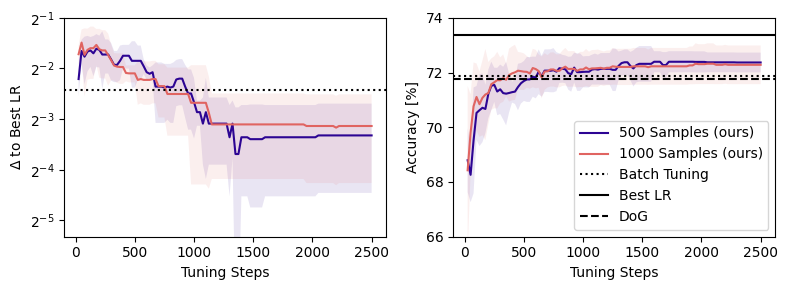

In [84]:
colors = {500: "#2C0493", 1000: "#E06461"}
linestyles = {"DoG": "dashed", "Best LR": "solid", "Batch Tuning": "dotted"}
vars_y = ["delta_best_lr", "accuracy"]
fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
dfp = stream_mean[
    (stream_mean["n_hidden_layers"] == 1) & (stream_mean["n_hidden_units"] == 64)
]
df_tune = dfp[(stream_mean["optimizer"] == "Pre-Tuning")]
for ax, var_y in zip(axs, vars_y):
    for n_samples, df_n_samples in df_tune.groupby("n_samples"):
        steps = df_n_samples["step"]
        scores = df_n_samples[f"{var_y}_mean"]
        stds = df_n_samples[f"{var_y}_std"]
        color = colors[n_samples]
        ax.plot(
            steps,
            scores,
            c=color,
            label=f"{int(n_samples)} Samples (ours)",
        )
        ax.fill_between(
            steps,
            scores - stds,
            scores + stds,
            color=color,
            edgecolor="none",
            alpha=0.1,
        )
    for baseline, df_base in dfp.groupby("optimizer"):
        if baseline == "Pre-Tuning" or (baseline == "DoG" and var_y == "delta_best_lr"):
            continue
        ax.axhline(
            df_base[f"{var_y}_mean"].item(),
            label=baseline,
            color="black",
            linestyle=linestyles[baseline],
        )
    ax.set_xlabel("Tuning Steps")

axs[0].set_yscale("log", base=2)
axs[0].set_ylim([0.025, 0.5])
axs[1].set_ylim([66, 74])
axs[0].set_ylabel(r"$\Delta$ to Best LR")
axs[1].set_ylabel("Accuracy [%]")
fig.tight_layout()
ax.legend()
fig.savefig("../pub/figures/pretune_1x64_acc_lr_exp_schedule.pdf")